# Integrated Disease Surveillance | Part 2 | ML Forecasting + Risk Classification


In [12]:
!pip install prophet

In [13]:
#  Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [14]:
# 2 Load Master Data
master = pd.read_csv('master_disease_surveillance.csv')

In [15]:
# 3. Feature Engineering: Lag features
master = master.sort_values(['district_code', 'week'])
master['cases_lag1'] = master.groupby('district_code')['cases_reported'].shift(1)
master['rainfall_lag1'] = master.groupby('district_code')['rainfall_mm'].shift(1)
master['humidity_lag1'] = master.groupby('district_code')['humidity'].shift(1)

master = master.dropna()

   year  week  cases_reported         ds    y
0  2025     2             198 2025-01-13  198
1  2025     3             280 2025-01-20  280
2  2025     4             166 2025-01-27  166
3  2025     5             167 2025-02-03  167
4  2025     6              21 2025-02-10   21


13:22:27 - cmdstanpy - INFO - Chain [1] start processing
13:22:30 - cmdstanpy - INFO - Chain [1] done processing


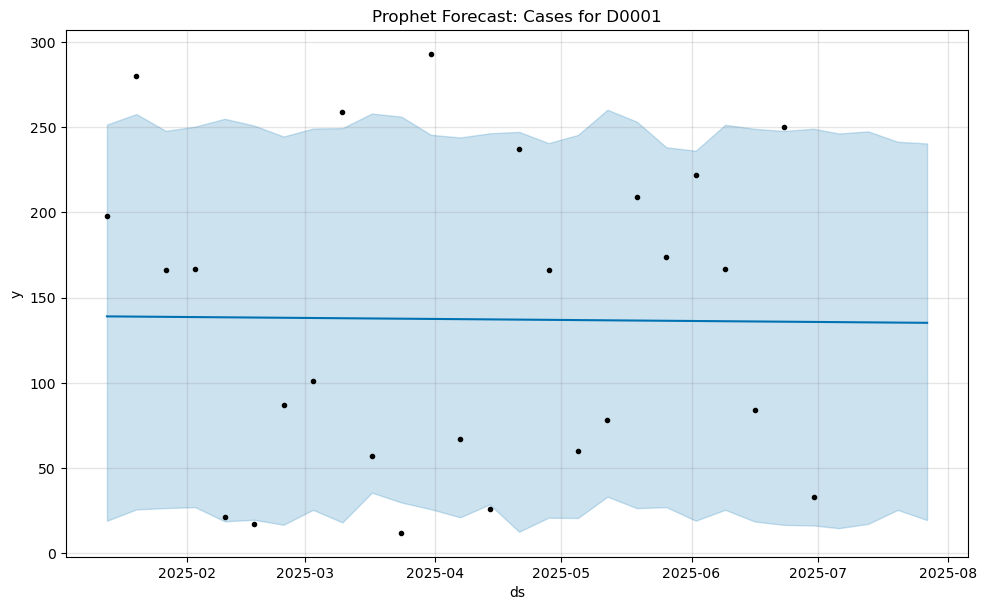

In [ ]:
#  4. Forecasting with Prophet (example for one district)
from datetime import datetime

# Filter for one district
dist = 'D0001'
dist_df = master[master['district_code'] == dist][['year', 'week', 'cases_reported']]

# Group by year & week in case there are duplicates
dist_df = dist_df.groupby(['year', 'week']).sum().reset_index()

# Convert year + week to a real date (Monday of that ISO week)
def week_to_date(row):
    return datetime.strptime(f'{int(row.year)}-{int(row.week)}-1', "%Y-%W-%w")

dist_df['ds'] = dist_df.apply(week_to_date, axis=1)
dist_df['y'] = dist_df['cases_reported']

print(dist_df.head())

# Prophet model
from prophet import Prophet

m = Prophet()
m.fit(dist_df[['ds', 'y']])

# Make future dataframe
future = m.make_future_dataframe(periods=4, freq='W')
forecast = m.predict(future)

# Plot forecast
fig1 = m.plot(forecast)
plt.title(f'Prophet Forecast: Cases for {dist}')
plt.show()


In [17]:
# 5. Risk Classification
# Define high risk if cases > 100
master['high_risk'] = np.where(master['cases_reported'] > 100, 1, 0)

features = ['cases_lag1', 'rainfall_lag1', 'humidity_lag1', 'vaccination_coverage']
X = master[features]
y = master['high_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))




[[   0 1807]
 [   0 3668]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1807
           1       0.67      1.00      0.80      3668

    accuracy                           0.67      5475
   macro avg       0.33      0.50      0.40      5475
weighted avg       0.45      0.67      0.54      5475

ROC AUC: 0.5


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✅ Confusion Matrix:
[[   0 1807]
 [   0 3668]]


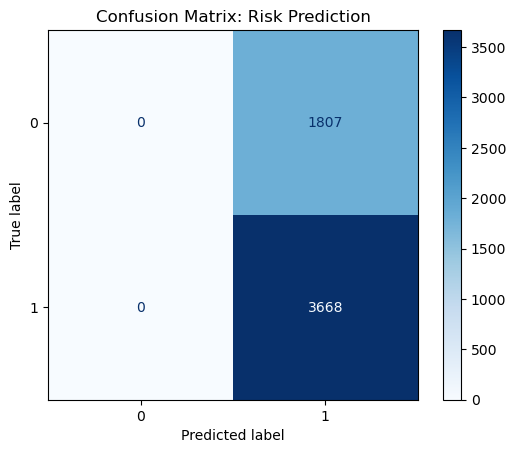


✅ Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1807
           1       0.67      1.00      0.80      3668

    accuracy                           0.67      5475
   macro avg       0.33      0.50      0.40      5475
weighted avg       0.45      0.67      0.54      5475



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# After predicting:
print("✅ Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Pretty plot of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Risk Prediction")
plt.show()

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))


In [19]:

# 6. Export final risk scores
X_test = X_test.copy()
X_test['predicted_risk'] = y_pred
X_test['district_code'] = master.loc[X_test.index, 'district_code']

# Example policy action: Flag risky districts
X_test['action'] = np.where(X_test['predicted_risk'] == 1, 'Increase Vaccination Drive', 'Monitor')

X_test.to_csv('risk_forecast_output.csv', index=False)
print('✅ Risk forecast file saved: risk_forecast_output.csv')

✅ Risk forecast file saved: risk_forecast_output.csv
